# Application d'une approche variationnelle pour un modèle de régression bayésien

In [1]:
"""""""""""""""""
Required packagesRequired packages

"""""""""""""""""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stat
from math import gamma
from scipy.stats import multivariate_normal

#### Modèle 

On considère un modèle de régression bayésien 

$$\\[1em]\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\epsilon}$$
 avec
 \begin{align*}
\mathbf{y} & = (y_1, y_2, \ldots, y_n) \in \mathbb{R}^n \\[1em]
\mathbf{X} & = \begin{pmatrix}
x_{1,1} & x_{1,2} & \ldots & x_{1,D} \\
x_{2,1} & x_{2,2} & \ldots & x_{2,D} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n,1} & x_{n,2} & \ldots & x_{n,D}
\end{pmatrix} \in \mathbb{R}^{n \times D} \\[1em]
\boldsymbol{\beta} & = (\beta_1, \beta_2, \ldots, \beta_D) \in \mathbb{R}^D\\[1em]
\\
\end{align*}
Et $\boldsymbol{\epsilon} \in \mathbb{R}^n$ un vecteur de $\mathcal{N}(0, \boldsymbol{\tau})$

Ici $\mathbf{X}$ et $\mathbf{y}$ sont observés, les variables latentes sont $\boldsymbol{\beta}$ et $\boldsymbol{\tau}$ .

Nous présentons ici un modèle de régression linéaire bayésien conditionnellement conjugué avec un ARD
a priori
On a ainsi $p(y | \beta, \tau ; x) = \prod_{i=1}^{n} \mathcal{N}(y_i | \beta^\top x_i, \tau)$.

Automatic relevance determination (ARD) attribue un a priori distinct à chaque coefficient de régression $\boldsymbol{\beta_d}$.
\begin{align*}
p(y ; x) &= p(y | \beta, \tau ; x)p(\beta, \tau)\,,\\
&=p(y | \beta, \tau ; x)p(\beta, \tau | \alpha)p(\alpha)\,,
\end{align*}


avec $p(\beta; \tau | \alpha) = \mathcal{N}(\beta | 0, \tau \text{diag}(\alpha)) \, \text{Gam}(\tau | a_0, b_0)
$

et $p(\alpha)$ la densité d'un produit de $\Gamma(c_0,d_0)$

On peut identifier $ a_0, b_0, c_0, d_0$ comme des hyperparamètres dont leure étude sera intéressante.


Attention : La notation $Loi(variable | parametre1, parametre2)$ signifie que la variable suit la loi Loi de paramètres : parametre1, parametre2.

Attention 2 : Dans la suite, on notera $V = \tau \text{diag}(\alpha)$ la variance de  $\beta$.


#### Dataset 

In [2]:
D = 20
N = 150
a0 = 1
b0 = 1
c0 = 1
d00 = 1
d0 = [d00 for _ in range(D)]

#Génération d'un tau
tau = stat.gamma.rvs(a0,b0)
alpha = [stat.gamma.rvs(c0,d) for d in d0]

# Génération d'un Beta
B = stat.norm.rvs(0,tau*np.diag(alpha)).diagonal()


# Génération d'une matrice X de taille (N, D)
X = np.random.rand(D,N)

y = np.array([X.T[i]@B + stat.norm.rvs(0,tau) for i in range (N)])

V = np.linalg.inv(c0 * np.diag(d0) + X@X.T)

 #### CAVI

La mise à jour pour l'algorithme cavi procurer par les articles mentionner ci-dessus est:

\begin{align*}
V_N &= \left( \frac{c_N}{d_{Ni}} I + \sum_{i=1}^n x_i x_i^T \right)^{-1} \\
\beta_N &= V_N \left( \sum_{i=1}^n x_i y_i \right) \\
a_N &= a_0 + \frac{N}{2} \\
c_N &= c_0 + \frac{1}{2} \\
b_N &= b_0 + \frac{1}{2} \left( \sum_{i=1}^n y_i^2 - \beta_N^T V_N^{-1} \beta_N + \text{tr}(V_N^{-1} V_1) \right) \\
d_{Ni} &= d_0 + \frac{1}{2} (\beta_{Ni})^2 \frac{a_N}{b_N} (V_N)_{ii}
\end{align*}



In [3]:
def update(beta,V,b,d,X,Y,a,c):
    V = np.linalg.inv(np.diag(c/d) + X@X.T)
    beta = V@X@Y
    b=0.5*np.sum(Y**2) -0.5*beta.T@V@beta + b0
    d = d0 + 0.5*(np.diag(V)+beta**2*a/b)
    return (beta, V, b, d)

La ELBO (Evidence Lower BOund) est calcule de la manière suivante:

\begin{align*}
L(Q) = - \frac{N}{2} \ln(2\pi) - \frac{1}{2} \frac{b_N}{a_N} \sum_{i=1}^n ((y_i - \beta_N^T x_i)^2 + x_i^T V_N x_i )+ \frac{1}{2} \ln \det(V_N) + \frac{D}{2} - \ln(\Gamma(a_0)) + a_0 \ln(b_0) - b_0 \frac{a_N}{b_n} + \ln(\Gamma(a_N))
+ a_N +\sum_{i=1}^n( \ln \Gamma(c_0) + c_0 \ln(d_0) - \ln \Gamma(c_N) + c_N \ln(d_{Ni}))
\end{align*}

In [4]:
def elbo(beta,V,a,b,c,d,X,Y):
    first_item = -np.sum([a/b*(Y[i]-beta.T@X.T[i])**2 + X.T[i]@V@X.T[i] for i in range(N)])/2
    ligne1 = -N/2*np.log(2*np.pi)+ first_item + 1/2*np.log(np.abs(np.linalg.det(V))) + D/2
    ligne2 = -np.log(gamma(a0))+a0*np.log(b0)-b0*a/b + np.log(gamma(a))-a*np.log(b)+a
    ligne3 = -np.log(gamma(c0)) + c0*np.log(d00)+np.log(gamma(c))-c*np.sum([np.log(di) for di in d])
    
    return ligne1 + ligne2 + ligne3

L'algorithme CAVI s'écrit alors:

In [5]:
def Cavi(beta,V,a,b,c,d,X,Y,max_iter,eps):
    a=a0+N/2
    c=c0+1/2
    elbos = [elbo(beta,V,a,b,c,d,X,Y)]
    beta_list = [beta]
    V_list =[V]
    b_list =[b]
    d_list = [d]
    dist_liste=[np.linalg.norm(beta-B)]
    for ite in range(1,max_iter+1):
       
        beta, V, b, d = update(beta,V,b,d,X,Y,a,c)
        V_list.append(V)
        b_list.append(b)
        d_list.append(d)
        beta_list.append(beta)
        dist_liste.append(np.linalg.norm(beta-B))
        
        elbos.append(elbo(beta,V,a,b,c,d,X,Y))
        if np.linalg.norm(elbos[-2] - elbos[-1]) <= eps:
            break
    
    
    return (elbos,beta_list,V_list,b_list,d_list,dist_liste)

In [6]:
max_iter = 5000
eps= 1e-3

In [7]:
atest=1e-2
btest=1e-4
ctest=1e-2
dtest=np.array([1e-4 for _ in range (D)])

tau = stat.gamma.rvs(atest,btest)
alpha = [stat.gamma.rvs(ctest,d) for d in dtest]



betatest = stat.norm.rvs(0,tau*np.diag(alpha)).diagonal()
Vtest = np.linalg.inv(ctest * np.diag(dtest) + np.sum([x@x.T for x in X]))


In [8]:
elbos, betas, Vs, bs, ds, dist = Cavi(betatest,Vtest,atest,btest,ctest,dtest,X,y,max_iter,eps)


Text(0.5, 1.0, 'evolution de la distance entre le beta approché et le vrai')

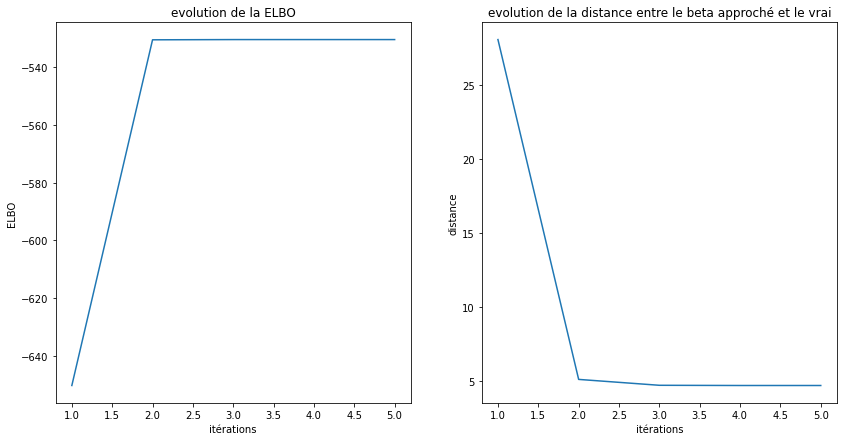

In [9]:
xx = np.arange(0,len(elbos),1)
fig,ax = plt.subplots(1,2,figsize=(14,7))
ax[0].plot(xx[1:],elbos[1:])
ax[0].set_xlabel("itérations")
ax[0].set_ylabel("ELBO")
ax[0].set_title("evolution de la ELBO")
ax[1].plot(xx[1:],dist[1:])
ax[1].set_xlabel("itérations")
ax[1].set_ylabel("distance")
ax[1].set_title("evolution de la distance entre le beta approché et le vrai")


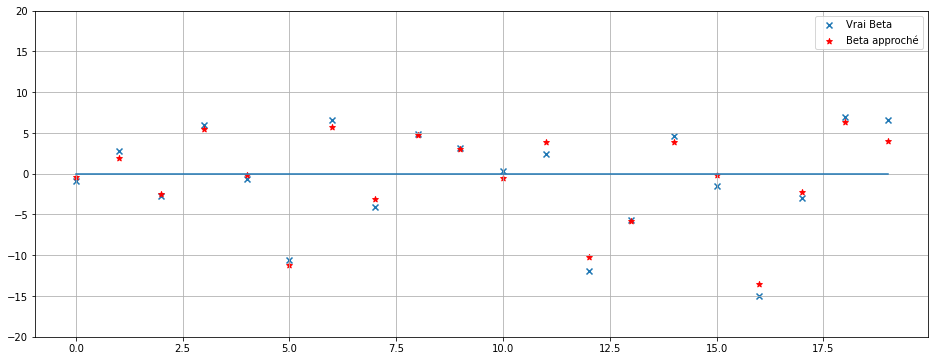

In [10]:
fig,ax=plt.subplots(1,1,figsize=(16,6))

xx=np.arange(0,D)
plt.scatter(xx,B,marker='x',label="Vrai Beta")
plt.scatter(xx,betas[-1],marker='*',color="red",label="Beta approché")
plt.plot(xx,np.zeros(D))
plt.grid()
plt.ylim([-20,20])
plt.legend()

On peut remarquer que comme l'on s'y attendait l'algorithme converge. Notamment on peut observer la ELBO se stabilise rapidement sur un plateau.

### Influence de l'initilisation des hyperparamètres sur l'estimation de $\boldsymbol{\beta}$

In [11]:
#Definition d'une fonction retournant un dataset en fonction des hyperparamètres

def data_gen(a0,b0,c0,d):
    
    tau = stat.gamma.rvs(a0,b0)
    alpha = [stat.gamma.rvs(c0,d) for d in d0]
    
    B = stat.norm.rvs(0,tau*np.diag(alpha)).diagonal()

    X = np.random.rand(D,N)
    y = np.array([X.T[i]@B + stat.norm.rvs(0,tau) for i in range (N)])

    V = np.linalg.inv(c0 * np.diag(d0) + X@X.T)
    return (X,y,B,V)

In [12]:
#Vrai parametre 
a=2
b=3
c=1
d=5

In [13]:
data = data_gen(a,b,c,d)

#vrai Beta
B = data[2]                 
          
#Observations
X = data[0]
y = data[1]

In [14]:
def ecart(a0,b0,c0,d0):
    
    dist=[]
    for _ in range (300):
        
        tau = stat.gamma.rvs(a0,b0)
        alpha = [stat.gamma.rvs(c0,d) for d in d0]
        beta0 = stat.norm.rvs(0,tau*np.diag(alpha)).diagonal()
        V0 = np.linalg.inv(ctest * np.diag(dtest) + np.sum([x@x.T for x in X]))
        
        dist.append(Cavi(beta0,V0,a0,b0,c0,d0,X,y,max_iter,eps)[5][-1])
        
    
    return np.array(dist).mean()

#### <font color=red>  Hyperparamètres petits</font>

Dans l'article de Drugowitsch, ils recommandent d'initialiser par défaut de la manière suivante:


In [15]:
a0, b0, c0, d0 = (1e-2,1e-4,1e-2,np.array([1e-4 for _ in range (D)]))


In [16]:
print(f"la distance moyenne a Beta est :{ecart(a0, b0 ,c0, d0)}")  #la ligne de code prend ~20 sec

la distance moyenne a Beta est :21.677135573899804


In [17]:
tau = stat.gamma.rvs(a0,b0)
alpha = [stat.gamma.rvs(c0,d) for d in d0]
beta0 = stat.norm.rvs(0,tau*np.diag(alpha)).diagonal()
V0 = np.linalg.inv(ctest * np.diag(dtest) + np.sum([x@x.T for x in X]))
    
    
print(f"le nombre d itération pour atteindre le critère de convergence est :{len(Cavi(beta0,V0,a0,b0,c0,d0,X,y,max_iter,eps)[0])}")

Beta1 = Cavi(beta0,V0,a0,b0,c0,d0,X,y,max_iter,eps)[1][-1]

le nombre d itération pour atteindre le critère de convergence est :32


#### <font color=red>  Hyperparamètres exacts</font>

In [18]:
a0, b0, c0, d0 = (2,3,1,5*np.ones(D))

In [19]:
print(f"la distance moyenne a Beta est :{ecart(a0, b0 ,c0, d0)}")

la distance moyenne a Beta est :7.956246028879989


In [20]:
tau = stat.gamma.rvs(a0,b0)
alpha = [stat.gamma.rvs(c0,d) for d in d0]
beta0 = stat.norm.rvs(0,tau*np.diag(alpha)).diagonal()
V0 = np.linalg.inv(ctest * np.diag(dtest) + np.sum([x@x.T for x in X]))
    
    
print(f"le nombre d itération pour atteindre le critère de convergence est :{len(Cavi(beta0,V0,a0,b0,c0,d0,X,y,max_iter,eps)[0])}")
Beta2 = Cavi(beta0,V0,a0,b0,c0,d0,X,y,max_iter,eps)[1][-1]

le nombre d itération pour atteindre le critère de convergence est :3


#### <font color=red>  Hyperparamètres grands</font>

In [21]:
a0, b0, c0, d0 = (10,36,52,60*np.ones(D))

In [22]:
print(f"la distance moyenne a Beta est :{ecart(a0, b0 ,c0, d0)}")

la distance moyenne a Beta est :7.783465720720299


In [23]:
tau = stat.gamma.rvs(a0,b0)
alpha = [stat.gamma.rvs(c0,d) for d in d0]
beta0 = stat.norm.rvs(0,tau*np.diag(alpha)).diagonal()
V0 = np.linalg.inv(ctest * np.diag(dtest) + np.sum([x@x.T for x in X]))
    
    
print(f"le nombre d itération pour atteindre le critère de convergence est :{len(Cavi(beta0,V0,a0,b0,c0,d0,X,y,max_iter,eps)[0])}")
Beta3 = Cavi(beta0,V0,a0,b0,c0,d0,X,y,max_iter,eps)[1][-1]

le nombre d itération pour atteindre le critère de convergence est :3


On remarque que plus les hyperparamètres initiaux sont grands, mieux $\boldsymbol{\beta}$ sera approché.
Ce qui change également est la vitesse de convergence de Cavi. En effet on l'identifie bien avec ce graphe :


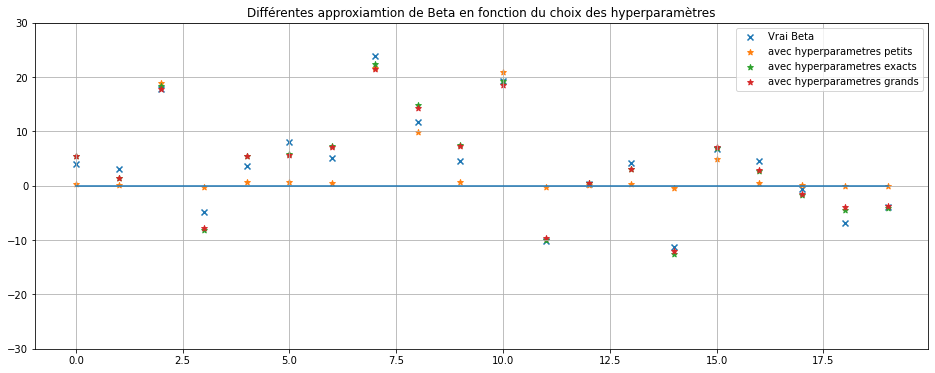

In [24]:
fig,ax=plt.subplots(1,1,figsize=(16,6))

xx=np.arange(0,D)
plt.scatter(xx,B,marker='x',label="Vrai Beta")
plt.scatter(xx,Beta1,marker='*',label="avec hyperparametres petits")
plt.scatter(xx,Beta2,marker='*',label="avec hyperparametres exacts")
plt.scatter(xx,Beta3,marker='*',label="avec hyperparametres grands")
plt.plot(xx,np.zeros(D))
plt.grid()
plt.ylim([-30,30])
plt.title("Différentes approxiamtion de Beta en fonction du choix des hyperparamètres")
plt.legend()

Pour des hyperparamètres arbitrairement grands la convergence est beaucoup plus rapide qu'avec les recommandés.

On peut conclure que l'initialisation des hyperparamètres a une influence sur la distance moyenne au vrai $\boldsymbol{\beta}$.
De plus, initilaisés trop près de 0, les hyperparamètres vont entrainer une mauvaise approximation de $\boldsymbol{\beta}$ en effet elle a un effet de "shrinkage".

### Approche frequentiste

Cette fois ci $\boldsymbol{\beta}$ est tiré aléatoirement sans dépendre des hyperparamètres.

Le but étant de voir si l'algorithme permet d'associer des hyperparamètres au $\boldsymbol{\beta}$ que l'on identifie avec CAVI.

In [25]:
sgm =1

# Génération d'un Beta
B =  10*np.random.randn(D)


# Génération d'une matrice X de taille (N, D)
X = np.random.rand(D,N)

y = np.array([X.T[i]@B + stat.norm.rvs(0,sgm) for i in range (N)])


Reprenons les hyperparamètres étudiés dans la section précédente pour initailiser l'algorithme

In [26]:
a0, b0, c0, d0 = (2,3,1,5*np.ones(D))

In [27]:
tau = stat.gamma.rvs(a0,b0)
alpha = [stat.gamma.rvs(c0,d) for d in d0]
beta0 = stat.norm.rvs(0,tau*np.diag(alpha)).diagonal()
V0 = np.linalg.inv(c0 * np.diag(d0) + np.sum([x@x.T for x in X]))

In [28]:
elbos, betas, Vs, bs, ds, dist = Cavi(beta0,V0,a0,b0,b0,d0,X,y,max_iter,eps)

Ici, seulement V va nous intéresser.
Notre nouveau $\boldsymbol{\beta}$ sera la réalisation moyenne d'une normale multivariée avec V pour matrice de covariance qui correspond à la derniere mise à jour dans l'algorithme CAVI.

In [29]:

l=[]
for _ in range (500):
    l.append(multivariate_normal.rvs(np.zeros(D), Vs[-1]))
beta2 = [np.array(l[i]).mean() for i in range (D)]

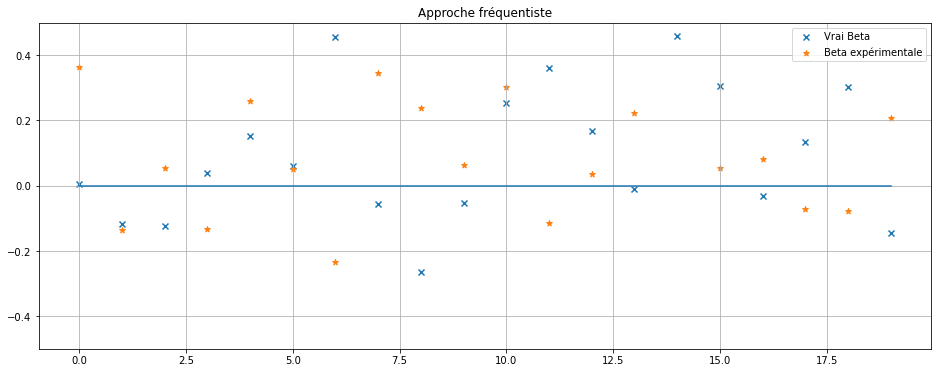

In [30]:
fig,ax=plt.subplots(1,1,figsize=(16,6))

xx=np.arange(0,D)
plt.scatter(xx,B/np.linalg.norm(B),marker='x',label="Vrai Beta")
plt.scatter(xx,beta2/np.linalg.norm(beta2),marker='*',label="Beta expérimentale")
plt.plot(xx,np.zeros(D))
plt.grid()
plt.ylim([-0.5,0.5])
plt.title("Approche fréquentiste")
plt.legend()

On remarque que ce nouveau $\boldsymbol{\beta}$ n'approche pas du tout le vrai $\boldsymbol{\beta}$.






### Sparsité

In [31]:
#Génération d'un tau
tau = stat.gamma.rvs(a0,b0)
alpha = [stat.gamma.rvs(c0,d) for d in d0]

# Génération d'un Beta
B = stat.norm.rvs(0,tau*np.diag(alpha)).diagonal()

B= list(B)
#sparsité
liste_0=[2,3,9,10,13,12,18]
for i in liste_0:
    B[i] = 0
    
# Génération d'une matrice X de taille (N, D)
X = np.random.rand(D,N)

y = np.array([X.T[i]@B + stat.norm.rvs(0,tau) for i in range (N)])

V = np.linalg.inv(c0 * np.diag(d0) + X@X.T)

In [32]:
a0, b0, c0, d0 = (2,3,1,5*np.ones(D))
tau = stat.gamma.rvs(a0,b0)
alpha = [stat.gamma.rvs(c0,d) for d in d0]
beta0 = stat.norm.rvs(0,tau*np.diag(alpha)).diagonal()
V0 = np.linalg.inv(c0 * np.diag(d0) + np.sum([x@x.T for x in X]))

In [33]:
elbos, betas, Vs, bs, ds, dist = Cavi(beta0,V0,a0,b0,b0,d0,X,y,max_iter,eps)

In [34]:
beta_new = betas[-1]

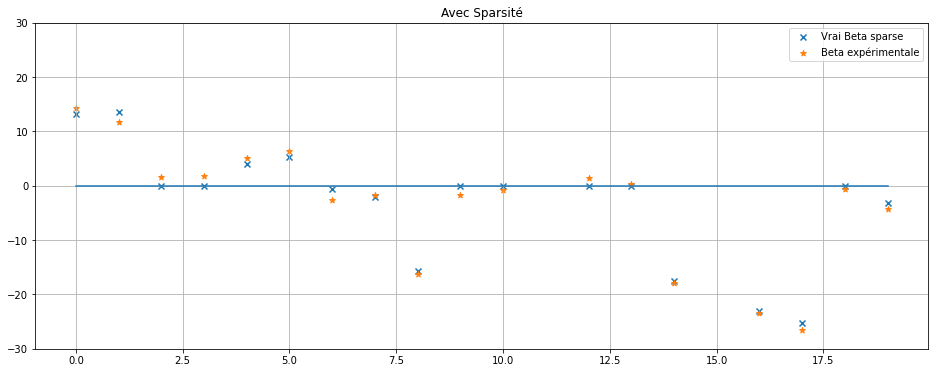

In [35]:
fig,ax=plt.subplots(1,1,figsize=(16,6))

xx=np.arange(0,D)
plt.scatter(xx,B,marker='x',label="Vrai Beta sparse")
plt.scatter(xx,beta_new,marker='*',label="Beta expérimentale")
plt.plot(xx,np.zeros(D))
plt.grid()
plt.ylim([-30,30])
plt.title("Avec Sparsité")
plt.legend()

On peut essayer de voir si la sparisté a une influence sur l'approximation en comparant la distance avec les éléments nuls et non nuls

In [36]:
nul = np.mean([B[i]-beta_new[i] for i in liste_0])
non_nul = np.mean([B[i]-beta_new[i] for i in range(len(B)) if i not in liste_0])

In [37]:
print(nul)
print(non_nul)

-0.2816727613572329
0.28409144126927466


En exécutant plusieurs fois les lignes de code supérieur, nous pouvons remarquer que la sparsité n'a pas d'influence sur l'approxiamtion de $\boldsymbol{\beta}$.